In [1]:
import pandas as pd
import numpy as np


# load
daily = pd.read_csv("/content/dailyActivity_merged.csv")
hr = pd.read_csv("/content/heartrate_seconds_merged.csv")
sleep = pd.read_csv("/content/minuteSleep_merged.csv")

print("Loaded:", len(daily), len(hr), len(sleep))


# dates
daily['ActivityDate'] = pd.to_datetime(daily['ActivityDate'], errors='coerce')
hr['Time'] = pd.to_datetime(hr['Time'], errors='coerce')
sleep['date'] = pd.to_datetime(sleep['date'], errors='coerce')


# clean
hr = hr.dropna(subset=['Time'])
sleep = sleep.dropna(subset=['date'])



# sleep daily
slp = sleep.copy()
slp['d'] = slp['date'].dt.date

sleep_daily = slp.groupby(['Id','d'])['value'].sum().reset_index()
sleep_daily.columns = ['Id','Date','TotalSleepMinutes']

sleep_daily['Date'] = pd.to_datetime(sleep_daily['Date'])



# hr daily
hr2 = hr.copy()
hr2['d'] = hr2['Time'].dt.date

hr_daily = hr2.groupby(['Id','d'])['Value'].mean().reset_index()
hr_daily.columns = ['Id','Date','AvgHeartRate']

hr_daily['Date'] = pd.to_datetime(hr_daily['Date'])



# prep
d2 = daily.copy()
d2['Date'] = d2['ActivityDate']



# merge
df = d2.merge(hr_daily, on=['Id','Date'], how='left')
df = df.merge(sleep_daily, on=['Id','Date'], how='left')

print("Merged:", df.shape)



# sensors
np.random.seed(42)

df["PM25"] = np.random.normal(80, 20, len(df))
df["PM10"] = np.random.normal(150, 40, len(df))
df["Temperature"] = np.random.normal(28, 3, len(df))
df["Humidity"] = np.random.normal(60, 10, len(df))



# hr fix
df["AvgHeartRate"] = df["AvgHeartRate"].fillna(df["AvgHeartRate"].median())



# flags
sleep_low = (df["TotalSleepMinutes"] < 400).astype(int)
steps_low = (df["TotalSteps"] < 7000).astype(int)
hr_high  = (df["AvgHeartRate"] > 90).astype(int)
pm_bad   = (df["PM25"] > 100).astype(int)
hot      = (df["Temperature"] > 32).astype(int)



# score
df["HealthRisk"] = sleep_low*2 + steps_low + hr_high*2 + pm_bad*2 + hot



# level
df["RiskLevel"] = pd.cut(
    df["HealthRisk"],
    bins=[-1, 2, 4, 50],
    labels=["Low", "Medium", "High"]
)

print(df[["HealthRisk","RiskLevel"]].head())



# users
users = df["Id"].unique()



# nodes
nodeA_u = users[:10]
nodeB_u = users[10:20]
nodeC_u = users[20:30]

nodeA = df[df["Id"].isin(nodeA_u)]
nodeB = df[df["Id"].isin(nodeB_u)]
nodeC = df[df["Id"].isin(nodeC_u)]

print("Nodes:", len(nodeA), len(nodeB), len(nodeC))



# save
nodeA.to_csv("/content/node_A.csv", index=False)
nodeB.to_csv("/content/node_B.csv", index=False)
nodeC.to_csv("/content/node_C.csv", index=False)

print("saved csvs")


Loaded: 457 1154681 198559
Merged: (457, 18)
   HealthRisk RiskLevel
0           0       Low
1           0       Low
2           0       Low
3           4    Medium
4           0       Low
Nodes: 135 156 110
saved csvs



=== info ===
rows: 457
cols: 24

=== cols ===
['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'Date', 'AvgHeartRate', 'TotalSleepMinutes', 'PM25', 'PM10', 'Temperature', 'Humidity', 'HealthRisk', 'RiskLevel']

=== head ===
           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-03-25       11004           7.11             7.11   
1  1503960366   2016-03-26       17609          11.55            11.55   
2  1503960366   2016-03-27       12736           8.53             8.53   
3  1503960366   2016-03-28       13231           8.93             8.93   
4  1503960366   2016-03-29       12041           7.85             7.85   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0

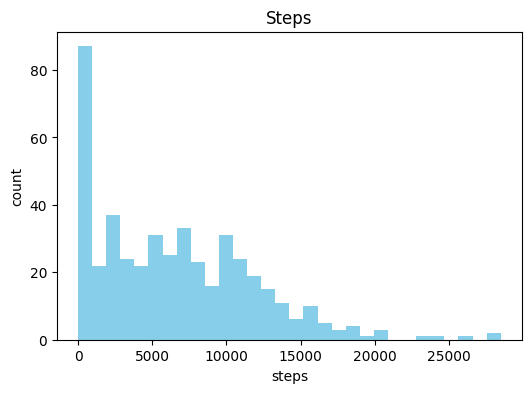

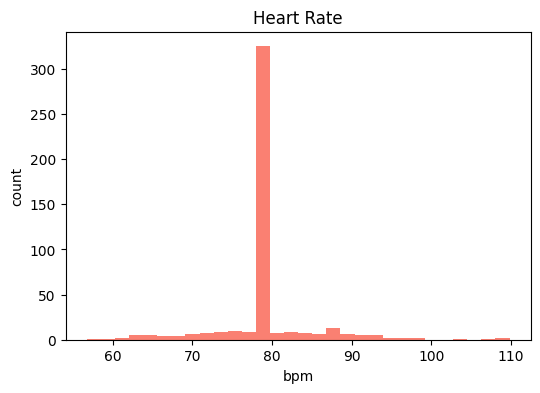

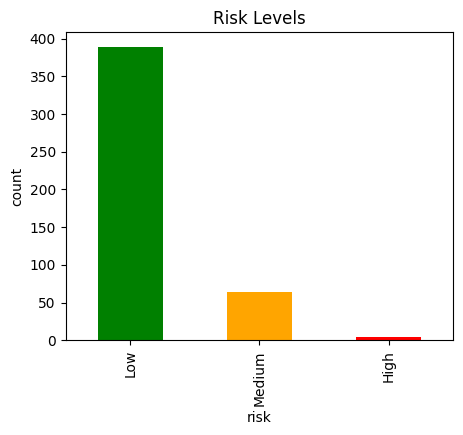

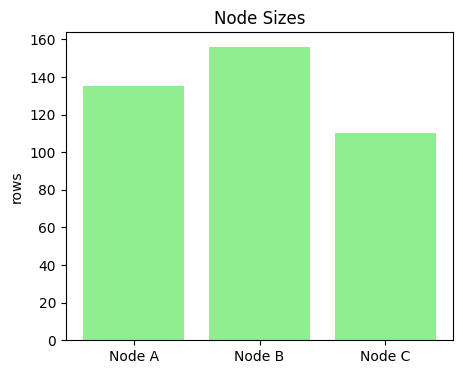

In [3]:
# info
print("\n=== info ===")
print("rows:", len(df))
print("cols:", df.shape[1])


# cols
print("\n=== cols ===")
print(list(df.columns))


# head
print("\n=== head ===")
print(df.head())


# nulls
print("\n=== nulls ===")
print(df.isnull().sum())


# stats
print("\n=== stats ===")
print(df.describe().T)


import matplotlib.pyplot as plt


# steps plot
plt.figure(figsize=(6,4))
plt.hist(df["TotalSteps"], bins=30, color='skyblue')
plt.title("Steps")
plt.xlabel("steps")
plt.ylabel("count")
plt.show()


# hr plot
plt.figure(figsize=(6,4))
plt.hist(df["AvgHeartRate"], bins=30, color='salmon')
plt.title("Heart Rate")
plt.xlabel("bpm")
plt.ylabel("count")
plt.show()


# risk plot
plt.figure(figsize=(5,4))
df["RiskLevel"].value_counts().plot(kind='bar', color=['green','orange','red'])
plt.title("Risk Levels")
plt.xlabel("risk")
plt.ylabel("count")
plt.show()


# node size
sizes = [len(nodeA), len(nodeB), len(nodeC)]
labs = ["Node A","Node B","Node C"]

plt.figure(figsize=(5,4))
plt.bar(labs, sizes, color="lightgreen")
plt.title("Node Sizes")
plt.ylabel("rows")
plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


# --- load ---
nodeA = pd.read_csv("/content/node_A.csv")
nodeB = pd.read_csv("/content/node_B.csv")
nodeC = pd.read_csv("/content/node_C.csv")


# --- small fill ---
feats = [
    "TotalSteps","TotalDistance","VeryActiveMinutes","Calories",
    "AvgHeartRate","TotalSleepMinutes","PM25","PM10",
    "Temperature","Humidity"
]

for node in [nodeA, nodeB, nodeC]:
    node[feats] = node[feats].fillna(node[feats].median())


# --- train fn ---
def train_local(df):

    df = df.copy()

    X = df[feats].values
    y = df["RiskLevel"]

    le = LabelEncoder()
    y = le.fit_transform(y)

    Xtr, Xts, Ytr, Yts = train_test_split(X, y, test_size=0.2, random_state=42)

    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr)
    Xts = sc.transform(Xts)

    mdl = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=100)
    mdl.fit(Xtr, Ytr)

    pred = mdl.predict(Xts)
    acc = accuracy_score(Yts, pred)

    return mdl, acc


# --- train nodes ---
mdlA, accA = train_local(nodeA)
mdlB, accB = train_local(nodeB)
mdlC, accC = train_local(nodeC)

print("\naccs")
print("A :", accA)
print("B :", accB)
print("C :", accC)


# --- get weights ---
def get_w(m):
    out = []
    for w in m.coefs_:
        out.append(w.copy())
    for b in m.intercepts_:
        out.append(b.copy())
    return out

wA = get_w(mdlA)
wB = get_w(mdlB)
wC = get_w(mdlC)

print("\nwts ok\n")


# --- print shapes ---
def w_shapes(w):
    shp = []
    for i, lay in enumerate(w):
        shp.append((i, lay.shape))
    return shp

print("-- shapes A --")
for i, s in w_shapes(wA): print("layer", i, ":", s)

print("\n-- shapes B --")
for i, s in w_shapes(wB): print("layer", i, ":", s)

print("\n-- shapes C --")
for i, s in w_shapes(wC): print("layer", i, ":", s)


# --- fix ---
base = [x.shape for x in wA]


def fix_w(w, ref):
    fixed = []
    for lay, shp in zip(w, ref):

        if lay.shape == shp:
            fixed.append(lay.copy())
        else:
            flat = lay.flatten()
            need = np.prod(shp)

            if len(flat) >= need:
                new = flat[:need]
            else:
                pad = need - len(flat)
                new = np.concatenate([flat, np.zeros(pad)])

            fixed.append(new.reshape(shp))

    return fixed


wB_fix = fix_w(wB, base)
wC_fix = fix_w(wC, base)


print("\n-- shapes B fixed --")
for i, s in w_shapes(wB_fix): print("layer", i, ":", s)

print("\n-- shapes C fixed --")
for i, s in w_shapes(wC_fix): print("layer", i, ":", s)

print("\nAll shapes fixed and ready for FedAvg.")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



accs
A : 0.8888888888888888
B : 0.90625
C : 0.9090909090909091

wts ok

-- shapes A --
layer 0 : (10, 32)
layer 1 : (32, 16)
layer 2 : (16, 1)
layer 3 : (32,)
layer 4 : (16,)
layer 5 : (1,)

-- shapes B --
layer 0 : (10, 32)
layer 1 : (32, 16)
layer 2 : (16, 3)
layer 3 : (32,)
layer 4 : (16,)
layer 5 : (3,)

-- shapes C --
layer 0 : (10, 32)
layer 1 : (32, 16)
layer 2 : (16, 1)
layer 3 : (32,)
layer 4 : (16,)
layer 5 : (1,)

-- shapes B fixed --
layer 0 : (10, 32)
layer 1 : (32, 16)
layer 2 : (16, 1)
layer 3 : (32,)
layer 4 : (16,)
layer 5 : (1,)

-- shapes C fixed --
layer 0 : (10, 32)
layer 1 : (32, 16)
layer 2 : (16, 1)
layer 3 : (32,)
layer 4 : (16,)
layer 5 : (1,)

All shapes fixed and ready for FedAvg.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
# --- fedavg ---
def avg_w(ws):
    out = []
    for group in zip(*ws):
        out.append(np.mean(group, axis=0))
    return out

g_w = avg_w([wA, wB_fix, wC_fix])

print("\nFedAvg done.\n")


# --- build global ---
global_m = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=1)

# dummy init (needed by sklearn)
global_m.fit(np.zeros((5,10)), np.zeros(5))

n = len(global_m.coefs_)

global_m.coefs_ = g_w[:n]
global_m.intercepts_ = g_w[n:]

print("Global model ready!")



FedAvg done.

Global model ready!


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


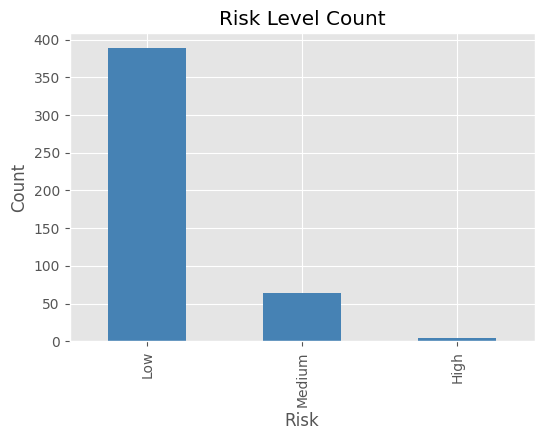

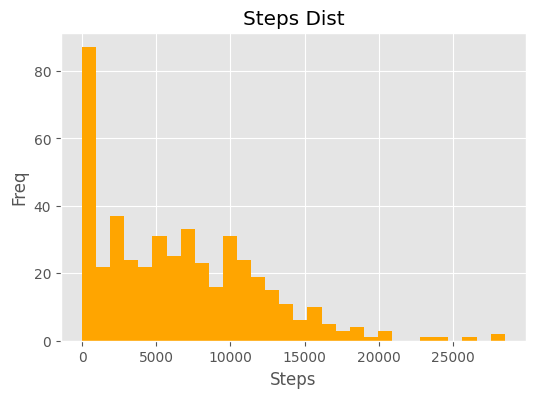

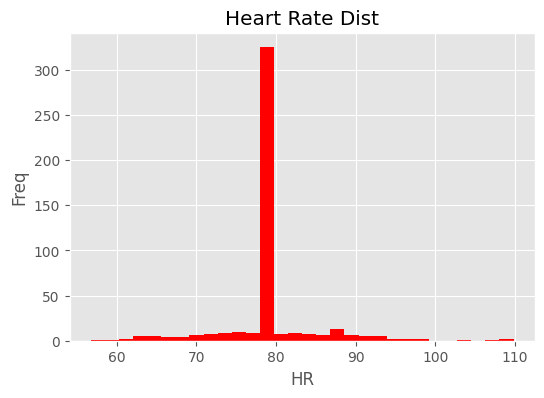

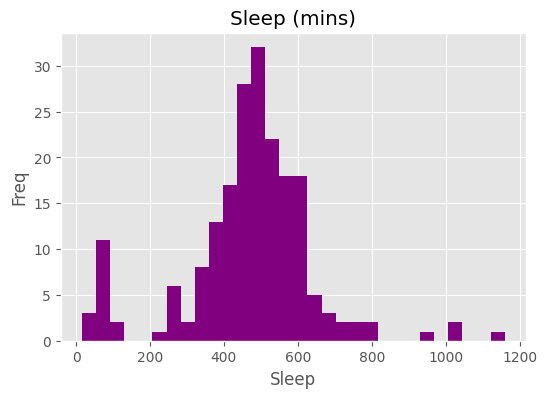

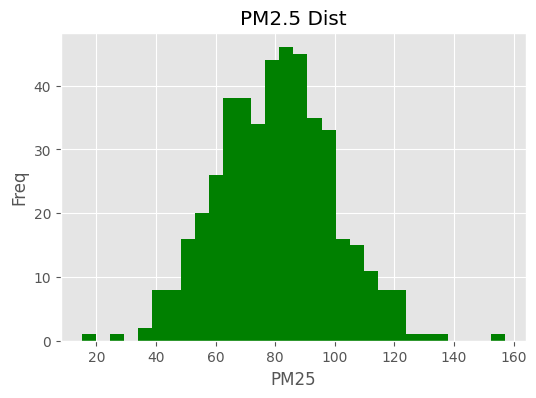

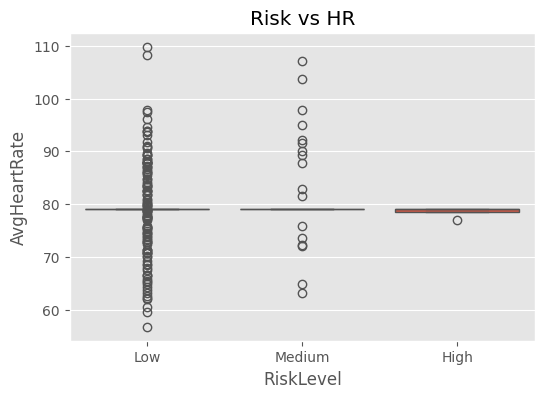

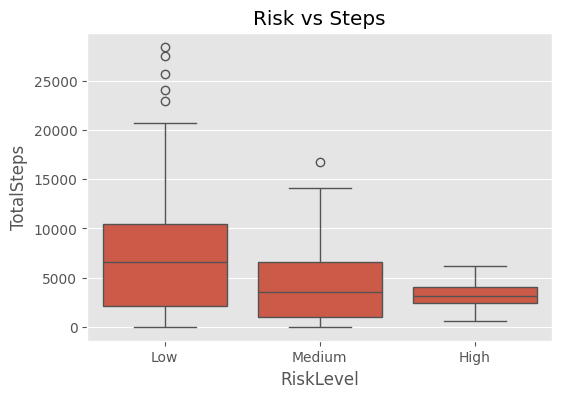

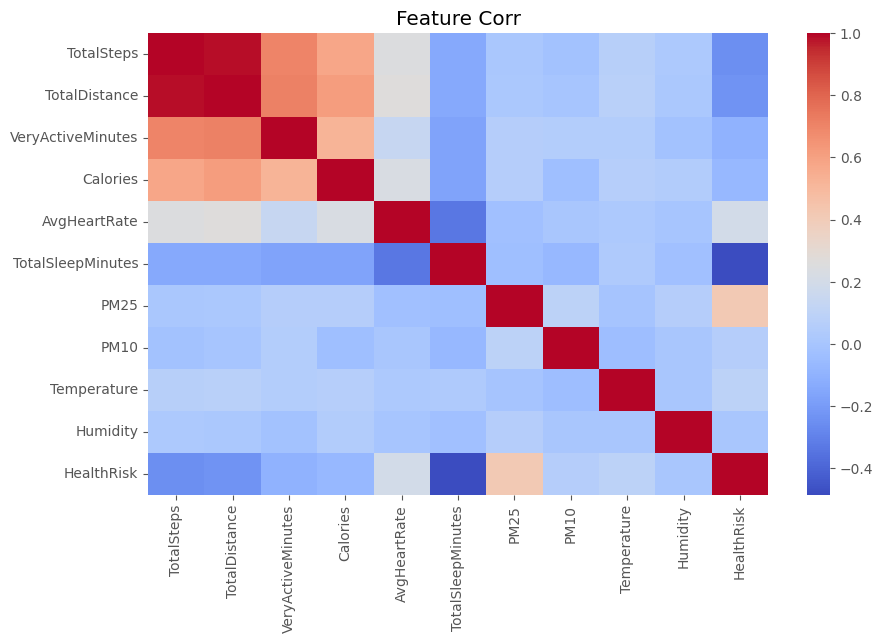

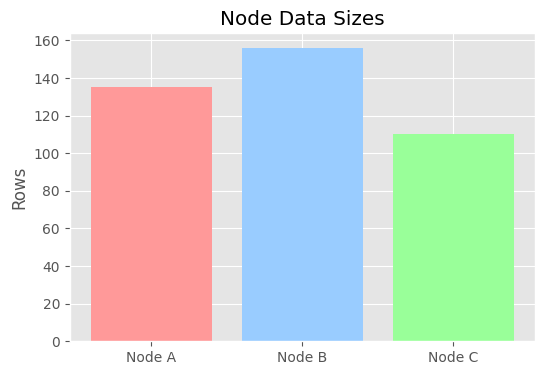

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# short
plt.style.use("ggplot")


# ---- 1. risk count ----
plt.figure(figsize=(6,4))
df["RiskLevel"].value_counts().plot(kind="bar", color="steelblue")
plt.title("Risk Level Count")
plt.xlabel("Risk")
plt.ylabel("Count")
plt.show()


# ---- 2. steps ----
plt.figure(figsize=(6,4))
plt.hist(df["TotalSteps"], bins=30, color="orange")
plt.title("Steps Dist")
plt.xlabel("Steps")
plt.ylabel("Freq")
plt.show()


# ---- 3. HR ----
plt.figure(figsize=(6,4))
plt.hist(df["AvgHeartRate"], bins=30, color="red")
plt.title("Heart Rate Dist")
plt.xlabel("HR")
plt.ylabel("Freq")
plt.show()


# ---- 4. sleep ----
plt.figure(figsize=(6,4))
plt.hist(df["TotalSleepMinutes"], bins=30, color="purple")
plt.title("Sleep (mins)")
plt.xlabel("Sleep")
plt.ylabel("Freq")
plt.show()


# ---- 5. air (PM2.5) ----
plt.figure(figsize=(6,4))
plt.hist(df["PM25"], bins=30, color="green")
plt.title("PM2.5 Dist")
plt.xlabel("PM25")
plt.ylabel("Freq")
plt.show()


# ---- 6. risk by HR ----
plt.figure(figsize=(6,4))
sns.boxplot(x=df["RiskLevel"], y=df["AvgHeartRate"])
plt.title("Risk vs HR")
plt.show()


# ---- 7. risk by steps ----
plt.figure(figsize=(6,4))
sns.boxplot(x=df["RiskLevel"], y=df["TotalSteps"])
plt.title("Risk vs Steps")
plt.show()


# ---- 8. corr ----
plt.figure(figsize=(10,6))
sns.heatmap(df[[
    "TotalSteps","TotalDistance","VeryActiveMinutes","Calories",
    "AvgHeartRate","TotalSleepMinutes","PM25","PM10",
    "Temperature","Humidity","HealthRisk"
]].corr(), annot=False, cmap="coolwarm")
plt.title("Feature Corr")
plt.show()


# ---- 9. node sizes ----
sizes = [len(nodeA), len(nodeB), len(nodeC)]

plt.figure(figsize=(6,4))
plt.bar(["Node A", "Node B", "Node C"], sizes, color=["#ff9999","#99ccff","#99ff99"])
plt.title("Node Data Sizes")
plt.ylabel("Rows")
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import numpy as np
import pandas as pd

# feats
feats = [
    "TotalSteps","TotalDistance","VeryActiveMinutes","Calories",
    "AvgHeartRate","TotalSleepMinutes","PM25","PM10",
    "Temperature","Humidity"
]

# prep
df_eval = df.copy()
df_eval[feats] = df_eval[feats].fillna(df_eval[feats].median())
Xg = df_eval[feats].values

# enc
from sklearn.preprocessing import LabelEncoder
lg = LabelEncoder()
y_true = lg.fit_transform(df_eval["RiskLevel"])

# scale
from sklearn.preprocessing import StandardScaler
sc_g = StandardScaler()
Xg = sc_g.fit_transform(Xg)

# pred
y_pred = global_m.predict(Xg)

# acc
acc_global = accuracy_score(y_true, y_pred)
print("\n=== Global Acc ===")
print(acc_global)

# cm
print("\n=== Conf Mat ===")
print(confusion_matrix(y_true, y_pred))

# rep
print("\n=== Report ===")
print(classification_report(y_true, y_pred, target_names=lg.classes_))


# base
base_mean = df_eval[feats].mean()
base_std  = df_eval[feats].std()

# new batch
new_batch = df_eval.sample(80, replace=True)
new_mean = new_batch[feats].mean()

# drift
drift = abs(new_mean - base_mean) / base_std
print("\n=== Drift z ===")
print(drift)

# flag
if (drift > 1.5).any():
    print("\n*** Drift Found ***")
else:
    print("\nNo drift.")

# save
joblib.dump(global_m, "global_model.pkl")
print("\nSaved : global_model.pkl\n")



=== Global Acc ===
0.0087527352297593

=== Conf Mat ===
[[  4   0   0]
 [389   0   0]
 [ 64   0   0]]

=== Report ===
              precision    recall  f1-score   support

        High       0.01      1.00      0.02         4
         Low       0.00      0.00      0.00       389
      Medium       0.00      0.00      0.00        64

    accuracy                           0.01       457
   macro avg       0.00      0.33      0.01       457
weighted avg       0.00      0.01      0.00       457


=== Drift z ===
TotalSteps           0.077292
TotalDistance        0.080878
VeryActiveMinutes    0.008692
Calories             0.052833
AvgHeartRate         0.114531
TotalSleepMinutes    0.082323
PM25                 0.195866
PM10                 0.000065
Temperature          0.023832
Humidity             0.051123
dtype: float64

No drift.

Saved : global_model.pkl



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-1791587856.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


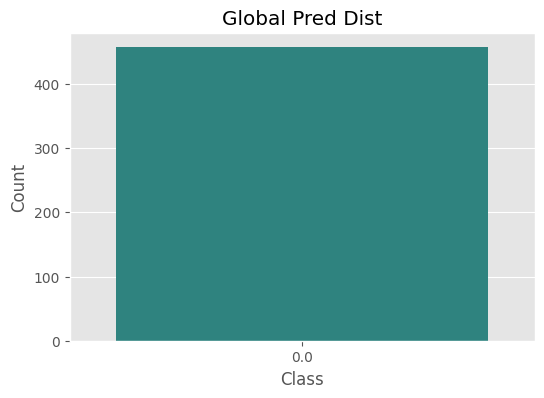

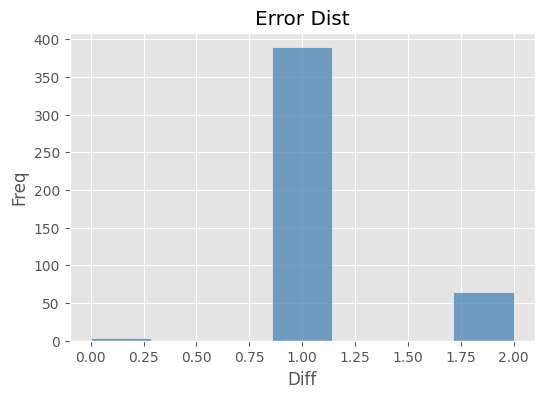

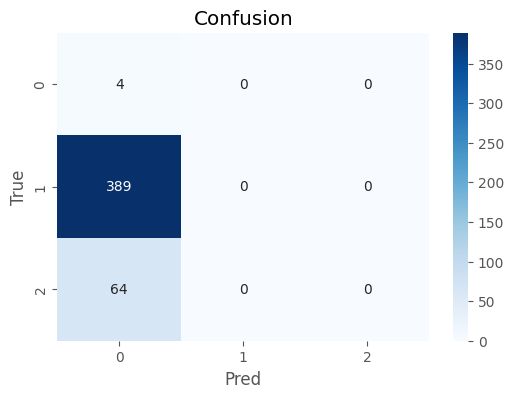

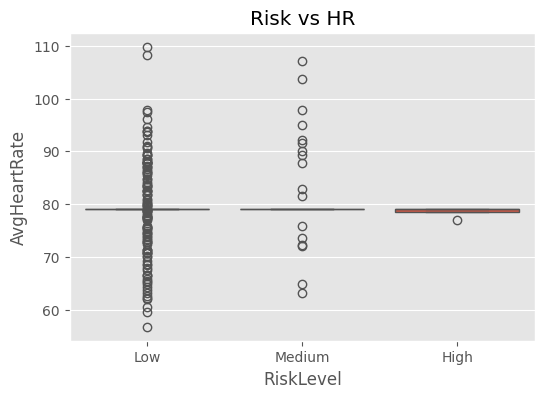

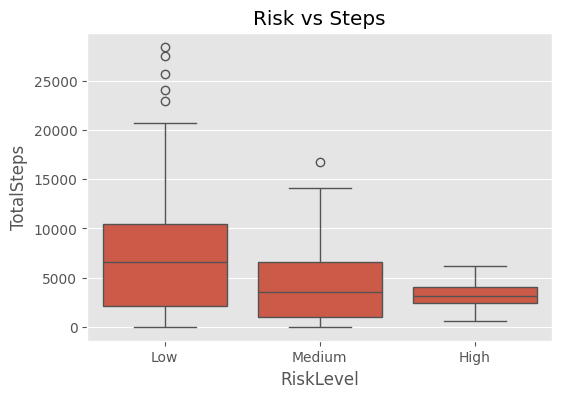

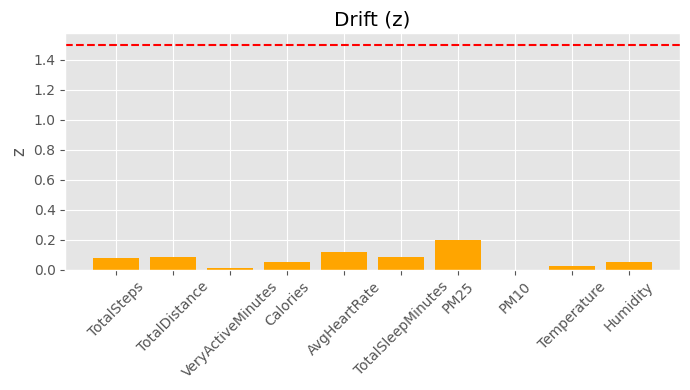

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# style
plt.style.use("ggplot")


# preds
plt.figure(figsize=(6,4))
sns.countplot(x=y_pred, palette="viridis")
plt.title("Global Pred Dist")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


# err
plt.figure(figsize=(6,4))
sns.histplot(y_true - y_pred, bins=7, color="steelblue")
plt.title("Error Dist")
plt.xlabel("Diff")
plt.ylabel("Freq")
plt.show()


# cm
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion")
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()


# HR
plt.figure(figsize=(6,4))
sns.boxplot(x=df_eval["RiskLevel"], y=df_eval["AvgHeartRate"])
plt.title("Risk vs HR")
plt.show()


# steps
plt.figure(figsize=(6,4))
sns.boxplot(x=df_eval["RiskLevel"], y=df_eval["TotalSteps"])
plt.title("Risk vs Steps")
plt.show()


# drift
plt.figure(figsize=(7,4))
plt.bar(drift.index, drift.values, color="orange")
plt.axhline(1.5, color="red", linestyle="--")
plt.xticks(rotation=45)
plt.title("Drift (z)")
plt.ylabel("z")
plt.tight_layout()
plt.show()


In [18]:
!pip install mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.5 MB/s eta 0:00:00


In [19]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# exp
mlflow.set_experiment("HealthRisk_FL")

# run
with mlflow.start_run():

    # acc
    mlflow.log_metric("accA", accA)
    mlflow.log_metric("accB", accB)
    mlflow.log_metric("accC", accC)
    mlflow.log_metric("accG", acc_global)

    # param
    mlflow.log_param("hidden", "32-16")
    mlflow.log_param("nodes", 3)

    # cm png
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", fmt="d")
    plt.title("Conf")
    plt.tight_layout()
    plt.savefig("cm.png")
    plt.close()

    # save
    mlflow.log_artifact("cm.png")

print("\nmlflow ok\n")


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/23 06:38:08 INFO mlflow.tracking.fluent: Experiment with name 'HealthRisk_FL' does not exist. Creating a new experiment.



mlflow ok



In [23]:
%%writefile fastapi_app.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

model = joblib.load("global_model.pkl")
labels = ["Low","Medium","High"]

app = FastAPI()

class Inp(BaseModel):
    TotalSteps: float
    TotalDistance: float
    VeryActiveMinutes: float
    Calories: float
    AvgHeartRate: float
    TotalSleepMinutes: float
    PM25: float
    PM10: float
    Temperature: float
    Humidity: float

@app.post("/predict")
def pred(data: Inp):

    x = np.array([
        data.TotalSteps,
        data.TotalDistance,
        data.VeryActiveMinutes,
        data.Calories,
        data.AvgHeartRate,
        data.TotalSleepMinutes,
        data.PM25,
        data.PM10,
        data.Temperature,
        data.Humidity
    ]).reshape(1,-1)

    p = model.predict(x)[0]

    return {
        "risk_code": int(p),
        "risk_level": labels[int(p)]
    }


Writing fastapi_app.py


In [24]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# app
app = FastAPI()

# load
model = joblib.load("global_model.pkl")


# req
class Input(BaseModel):
    TotalSteps: float
    TotalDistance: float
    VeryActiveMinutes: float
    Calories: float
    AvgHeartRate: float
    TotalSleepMinutes: float
    PM25: float
    PM10: float
    Temperature: float
    Humidity: float


# map
labels = ["Low", "Medium", "High"]


# home
@app.get("/")
def home():
    return {"msg": "HealthRisk API ok"}


# pred
@app.post("/predict")
def predict(data: Input):

    x = np.array([
        data.TotalSteps,
        data.TotalDistance,
        data.VeryActiveMinutes,
        data.Calories,
        data.AvgHeartRate,
        data.TotalSleepMinutes,
        data.PM25,
        data.PM10,
        data.Temperature,
        data.Humidity
    ]).reshape(1, -1)

    pred = model.predict(x)[0]

    return {
        "risk_code": int(pred),
        "risk_level": labels[int(pred)]
    }


In [21]:
!pip install fastapi uvicorn



ERROR:    Error loading ASGI app. Could not import module "fastapi_app".


In [25]:
!uvicorn fastapi_app:app --host 0.0.0.0 --port 8000


INFO:     Started server process [10359]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Finished server process [10359]
ERROR:    Traceback (most recent call last):
  File "/usr/lib/python3.12/asyncio/runners.py", line 195, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/base_events.py", line 678, in run_until_complete
    self.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self.

https://8000-m-s-1iykb8xrfpv3x-b.us-central1-0.prod.colab.dev
